In [ ]:
import os
import pandas as pd
import numpy as np
import sklearn
import tensorflow as tf
import shutil
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score, classification_report

from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.models import load_model
from PIL import Image
from matplotlib import pyplot as plt

In [ ]:
# Image variables
im_width  = 100
im_height = 100

# Path Variables
data_path   = '../gtsrb-german-traffic-sign/versions/1/'

In [ ]:
df_meta  = pd.read_csv(data_path + 'Meta.csv', delimiter=',')
df_test  = pd.read_csv(data_path + 'Test.csv', delimiter=',')
df_train = pd.read_csv(data_path + 'Train.csv', delimiter=',')

# Define the list of ClassIds representing speed limit signs
speed_limit_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8]

# Extract rows corresponding to speed limit signs (positive class)
speed_limit_df = df_train[df_train['ClassId'].isin(speed_limit_classes)].copy()

# Label these as speed limit (binary label = 1)
speed_limit_df['is_speed_limit'] = 1

# Extract rows corresponding to all other traffic signs (negative class)
others_df = df_train[~df_train['ClassId'].isin(speed_limit_classes)].copy()

# Randomly sample an equal number of rows as in the speed limit class to balance the dataset
others_sample_df = others_df.sample(n=len(speed_limit_df), random_state=42)
others_sample_df['is_speed_limit'] = 0

# Combine the two dataframes and shuffle the rows
binary_df = pd.concat([speed_limit_df, others_sample_df]).sample(frac=1, random_state=42)

# Save the binary CSV
binary_df.to_csv("binary.csv", index=False)

['balanced_data.csv', 'Meta', 'Meta.csv', 'Test', 'Test.csv', 'Train', 'Train.csv']


In [ ]:
# Add a new column 'is_speed_limit': 1 if ClassId is in speed_limit_classes, otherwise 0
df_test['is_speed_limit'] = df_test['ClassId'].apply(lambda x: 1 if x in speed_limit_classes else 0)

# Filter rows: one for speed limit images and another for other images
speed_limit_df = df_test[df_test['is_speed_limit'] == 1]
others_df = df_test[df_test['is_speed_limit'] == 0]

# Sample an equivalent number of non-speed limit images
n_speed = len(speed_limit_df)
others_sample = others_df.sample(n=n_speed, random_state=42)

# Combine the two subsets and shuffle them
binary_test_df = pd.concat([speed_limit_df, others_sample]).sample(frac=1, random_state=42)

# # Optionally, update file paths if necessary, e.g. prepend the base directory:
# binary_test_df['Path'] = binary_test_df['Path'].apply(lambda x: './gtsrb-german-traffic-sign/versions/1/' + x)

# Save the resulting binary test dataset to a CSV file
binary_test_df.to_csv("binary_test.csv", index=False)

In [ ]:
print(binary_df['is_speed_limit'].value_counts())

is_speed_limit
1    13200
0    13200
Name: count, dtype: int64


In [ ]:
print(binary_test_df['is_speed_limit'].value_counts())

is_speed_limit
0    4320
1    4320
Name: count, dtype: int64


In [ ]:
# Path to CSV file
csv_path = "../gtsrb-german-traffic-sign/versions/1/binary.csv"
df = pd.read_csv(csv_path)

# Create a new directory to store filtered images
dest_root = "binary_dataset"
os.makedirs(dest_root, exist_ok=True)

# Define subfolders for each class
speed_limit_folder = os.path.join(dest_root, "speed_limit")
others_folder = os.path.join(dest_root, "others")
os.makedirs(speed_limit_folder, exist_ok=True)
os.makedirs(others_folder, exist_ok=True)

# Iterate over each row in the CSV and copy images accordingly
for _, row in df.iterrows():
    # Assuming the CSV has columns 'Path' and 'is_speed_limit'
    src_path = "../gtsrb-german-traffic-sign/versions/1/"+row["Path"]
    label = row["is_speed_limit"]
    
    # Choose target folder based on the label
    target_folder = speed_limit_folder if label == 1 else others_folder
    
    # Get the file name from the source path
    file_name = os.path.basename(src_path)
    dest_path = os.path.join(target_folder, file_name)
    
    # Copy the file to the new destination
    shutil.copy(src_path, dest_path)


In [ ]:
# Path to CSV file
csv_path = "../gtsrb-german-traffic-sign/versions/1/binary_test.csv"
df = pd.read_csv(csv_path)

# Create a new directory to store filtered images
dest_root = "binary_dataset_test"
os.makedirs(dest_root, exist_ok=True)

# Define subfolders for each class
speed_limit_folder = os.path.join(dest_root, "speed_limit")
others_folder = os.path.join(dest_root, "others")
os.makedirs(speed_limit_folder, exist_ok=True)
os.makedirs(others_folder, exist_ok=True)

# Iterate over each row in the CSV and copy images accordingly
for _, row in df.iterrows():
    src_path = "../gtsrb-german-traffic-sign/versions/1/"+row["Path"]
    label = row["is_speed_limit"]
    
    # Choose target folder based on the label
    target_folder = speed_limit_folder if label == 1 else others_folder
    
    # Get the file name from the source path
    file_name = os.path.basename(src_path)
    dest_path = os.path.join(target_folder, file_name)
    
    # Copy the file to the new destination
    shutil.copy(src_path, dest_path)

In [ ]:
batch_size = 32

# Load training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory='./binary_dataset/',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(im_height, im_width),
    batch_size=batch_size
)

# Load validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    directory='.binary_dataset/',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(im_height, im_width),
    batch_size=batch_size
)

# Adding a normalization layer to our model
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

Found 26400 files belonging to 2 classes.
Using 21120 files for training.
Found 26400 files belonging to 2 classes.
Using 5280 files for validation.


In [ ]:
# Load the VGG16 base model without the classification head
base_model = tf.keras.applications.VGG16(weights="imagenet", include_top=False, 
                                         input_shape=(im_height, im_width, 3))
base_model.trainable = False  # Freeze the base model for initial training

# Custom classification model on top of the base model
model = tf.keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')  # One output neuron for binary classification
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Set up callbacks
# callbacks = [
#     tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
#     tf.keras.callbacks.ModelCheckpoint('best_binary_model.keras', monitor='val_loss', save_best_only=True)
# ]

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1,
    # callbacks=callbacks
)

660/660 ━━━━━━━━━━━━━━━━━━━━ 574s 867ms/step - accuracy: 0.9188 - loss: 0.1915 - val_accuracy: 0.9761 - val_loss: 0.0600


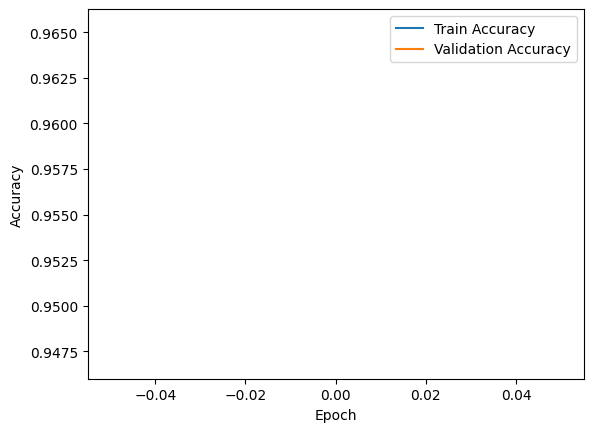

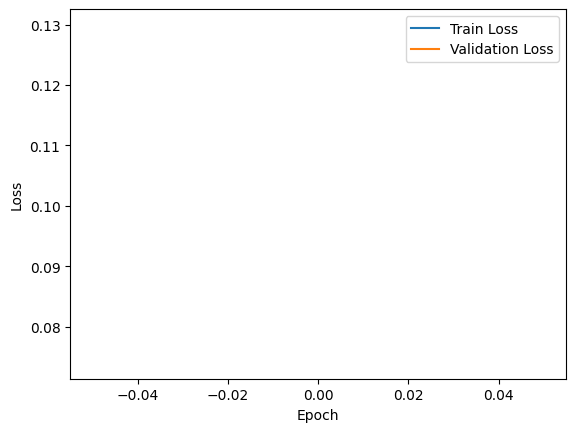

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory='./binary_dataset_test/',
    image_size=(im_height, im_width),
    batch_size=batch_size,
    shuffle=False  # Shuffle can be disabled for testing to maintain order
)

Found 8640 files belonging to 2 classes.


In [25]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.2f}")

270/270 ━━━━━━━━━━━━━━━━━━━━ 457s 2s/step - accuracy: 0.9345 - loss: 4.5544
Test Accuracy: 0.94


270/270 ━━━━━━━━━━━━━━━━━━━━ 237s 873ms/step
Confusion Matrix:
[[4020  300]
 [ 196 4124]]

Classification Report:
              precision    recall  f1-score   support

      others       0.95      0.93      0.94      4320
 speed_limit       0.93      0.95      0.94      4320

    accuracy                           0.94      8640
   macro avg       0.94      0.94      0.94      8640
weighted avg       0.94      0.94      0.94      8640



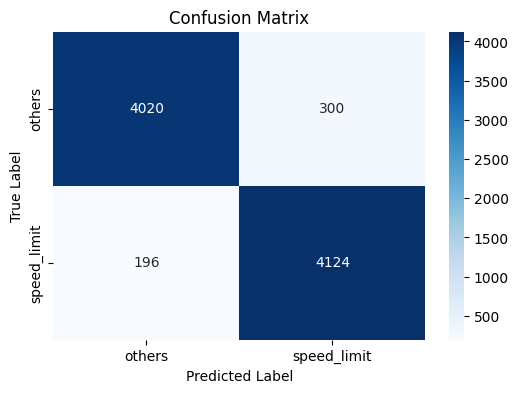

In [ ]:
# Gather true labels from the test dataset
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

# Generate prediction probabilities using the model
y_pred_probs = model.predict(test_ds)
# Convert probabilities to binary predictions (using 0.5 threshold)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Print a classification report for additional metrics
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["others", "speed_limit"]))

# Visualize the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["others", "speed_limit"], 
            yticklabels=["others", "speed_limit"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
Prediction: Speed sign


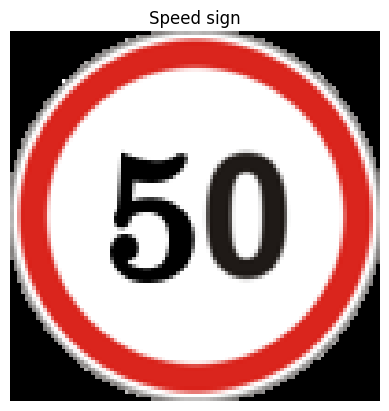

In [ ]:
# Path to image file
img_path = "../gtsrb-german-traffic-sign/versions/1/Meta/2.png" 

# Load the image and resize it
img = image.load_img(img_path, target_size=(im_height, im_width))
img_array = image.img_to_array(img)

# Normalize the image to [0,1]
img_array = img_array / 255.0

# Add a batch dimension (model expects a batch of images)
img_batch = np.expand_dims(img_array, axis=0)

# Make prediction
prediction_prob = model.predict(img_batch)[0][0]

# Convert prediction probability to a binary label (using 0.5 threshold)
if prediction_prob > 0.5:
    print("Prediction: Speed sign")
    result = "Speed sign"
else:
    print("Prediction: Not a speed sign")
    result = "Not a speed sign"

# Display the image with the prediction result
plt.imshow(img)
plt.title(result)
plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Prediction: Not a speed sign


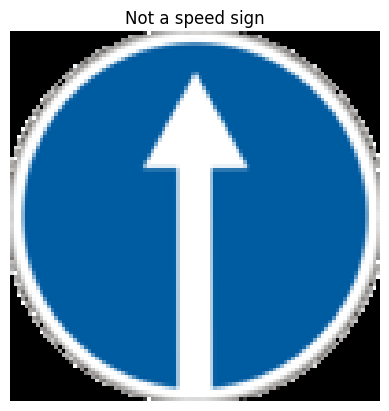

In [ ]:
# Path to image file
img_path = "../gtsrb-german-traffic-sign/versions/1/Meta/35.png"

# Load the image and resize it
img = image.load_img(img_path, target_size=(im_height, im_width))
img_array = image.img_to_array(img)

# Normalize the image to [0,1]
img_array = img_array / 255.0

# Add a batch dimension (model expects a batch of images)
img_batch = np.expand_dims(img_array, axis=0)

# Make prediction
prediction_prob = model.predict(img_batch)[0][0]

# Convert prediction probability to a binary label (using 0.5 threshold)
if prediction_prob > 0.5:
    print("Prediction: Speed sign")
    result = "Speed sign"
else:
    print("Prediction: Not a speed sign")
    result = "Not a speed sign"

# Display the image with the prediction result
plt.imshow(img)
plt.title(result)
plt.axis("off")
plt.show()